# Who Am I?

This is a Jupyter Notebook detailing a process where I:

* Take a pre-trained facial recognition model and use it to prune a corpus of iamges from my phone to those containing a face.
* Given vector embeddings generated over a small sample of training images, I identify pictures from the pruned corpus that feature me.
  
I will attempt to make this reproducible as well, such that anyone can supply their own photographs of themselves, and corpus from which they want to predict.

# Picking a model

After some light research around different facial recognition models, I've decided to proceed with DeepFace. It has some promising accuracy metrics, and starting from square one any model is as good as any other at this point. Per [this](https://www.fbi.gov/news/speeches-and-testimony/facial-recognition-technology-ensuring-transparency-in-government-use) report from the FBI in 2019, DeepFace was proven to be more accurate than their own internal facial recognition solutions.

In [1]:
import os
import pickle
import shutil
from PIL import Image
from deepface import DeepFace
from deepface.modules.detection import extract_faces
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import pytesseract
from pytesseract import Output
import torch
import clip


In [2]:
training_files = [os.getcwd()+'\\training_images\\'+x for x in os.listdir(os.getcwd()+'\\training_images')]
test_files = [os.getcwd()+'\\test_corpus\\'+x for x in os.listdir(os.getcwd()+'\\test_corpus')]

try:
    with open("test_embeddings_filtered.pkl", "rb") as f:
        test_embeddings_filtered = pickle.load(f)
    with open("train_embeddings.pkl", "rb") as f:
        train_embeddings = pickle.load(f)

except:
    None

In [3]:
from concurrent.futures import ThreadPoolExecutor
from deepface import DeepFace

# Leaning on DeepFace.represent to extract an embedding or return False if no face detected
def face_embed(file, enforce_detection = True):
    try:
        faces = [x['embedding'] for x in DeepFace.represent(img_path=file, detector_backend="retinaface", enforce_detection=enforce_detection)]
        return faces
    except Exception:
        return False

# Parallel face detection, preserving order
def face_embed_in_order(test_files, max_workers=8, enforce_detection = True):
    results = [None] * len(test_files)  
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_idx = {executor.submit(face_embed, file, enforce_detection): idx for idx, file in enumerate(test_files)}
        for future in future_to_idx:
            idx = future_to_idx[future]
            results[idx] = future.result()  # Store result at correct position
    return results

if 'test_embeddings_filtered' in globals():
    None
else:
    # the first step of generating all the embeddings or False placeholders
    test_embeddings = face_embed_in_order(test_files, max_workers=8)
    # removes any picture that could not generate embeddings due to no face
    test_embeddings_filtered = [(x, y) for (x,y) in list(zip(test_files, returned_embeddings)) if y != False]
    # saves to .pkl so no need to repeat later.
    with open("test_embeddings_filtered.pkl", "wb") as f:
        pickle.dump(test_embeddings_filtered, f)

if 'train_embeddings' in globals():
    None
else:
    # the first step of generating all the embeddings or False placeholders
    train_embeddings = face_embed_in_order(training_files, max_workers=8, enforce_detection = False)
    # saves to .pkl so no need to repeat later.
    with open("train_embeddings.pkl", "wb") as f:
        pickle.dump(train_embeddings, f)
    

In [5]:
# separating our test corpus into a new sub-corpus of pictures explicitly containing faces
os.makedirs('test_corpus\\has_faces', exist_ok = True)

for file in [x for (x,y) in test_embeddings_filtered]:
    name = os.path.basename(file)

    dest = os.path.join('test_corpus\\has_faces', name)

    shutil.move(file, dest)
    

So, I've used the function `DeepFace.represent` extensively so far to generate vector embeddings for every face in my test corpus (returning False when no face is detected as a useful filter to indicate what pictures can be excluded from this) and also generate vector embeddings for my 20 training images. My training images are just pics of myself looking in different directions with different glasses on. I could get more in depth with this and wear hats, take pics in bright light, low light, etc. But I think I can get reasonably good results with just these 20 photos alone - I hope.


# Method 1 - Mean Vector Embedding + Distance Metric Threshold

The first way I'm going to go about this is average all the vector embeddings from the training photos so I have one aggregate vector embedding representation of my face. From this, I will calculate distance (either co-sine or Euclidean) from every vector embedding in my test data to my aggregate vector embedding. Then I'll pick some threshold of distance from which I can say below will be no pictures of me and then judge my own performance.

In [4]:
import numpy as np
test_files_w_faces = [os.getcwd()+'\\test_corpus\\has_faces\\'+x for x in os.listdir(os.getcwd()+'\\test_corpus\\has_faces')]
agg_my_face = np.mean(np.array([np.array(x[0]) for x in train_embeddings]), axis = 0)

In [5]:
all_distances = []
# for every tuple that contains (filepath, embeddings)
for pic in test_embeddings_filtered:
    pic_dist = []
    # for every face embedding
    for _ in pic[1]:
        #calculate the euclidean distance from my face vector embedding
        face_dist = np.linalg.norm(np.array(_) - agg_my_face)
        #append to an inner list
        pic_dist.append(face_dist)
    #append to the outer list
    all_distances.append(pic_dist)
    
tagged_embeddings = [
    #index that will correspond filename from test_embeddings_filtered
    (outer_idx, embedding)
    for outer_idx, inner_list in enumerate(all_distances)
    for embedding in inner_list
]      

# sort the embeddings by distance
tagged_embeddings.sort(key = lambda x: x[1])

# correspond the index value to a filepath and I can cross-reference images to their score to cherry-pick an appropriate threshold
file_tagged_embeddings = [({x:y for (x, y) in list(enumerate(test_files_w_faces))}[x], y) for x, y in tagged_embeddings]

KeyError: 639

In [12]:
# The Euclidean distance of this photo (0.9685454522116286) seems to be a sweet spot.
# I'm starting to see (as a pattern) faces that have this distance or higher are typically not my face.
file_tagged_embeddings[730]

# separating the results with Euclidean distance threshold 0.9685454522116286 to visually scan the results
os.makedirs('test_corpus\\has_faces\\dist_thresh_9685454522116286', exist_ok = True)

for file in [x for x, y in file_tagged_embeddings if y < 0.9685454522116286]:
    name = os.path.basename(file)

    dest = os.path.join('test_corpus\\has_faces\\dist_thresh_9685454522116286', name)

    try:
        shutil.move(file, dest)
    except:
        continue
        

NameError: name 'file_tagged_embeddings' is not defined

This method using Euclidean distance hasn't proven too useful. There are enough false positives and negatives that I'm not pleased with the solution. Next I will try using cosine similarity. There's some writing online that this can be a better metric for facial recognition than Euclidean distance.

In [9]:
# a function that calculates cosine similarity
def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# a familiar looking for loop, adapted now for similarity instead of Euclidean distance
all_similarities = []
# for every tuple that contains (filepath, embeddings)
for pic in test_embeddings_filtered:
    pic_sim = []
    # for every face embedding
    for _ in pic[1]:
        #calculate the cosine similarity from my face vector embedding
        face_sim = cosine_similarity(_, agg_my_face)
        #append to an inner list
        pic_sim.append(face_sim)
    #append to the outer list
    all_similarities.append(pic_sim)
    
tagged_embeddings = [
    #index that will correspond filename from test_embeddings_filtered
    (outer_idx, embedding)
    for outer_idx, inner_list in enumerate(all_similarities)
    for embedding in inner_list
]      

# sort the embeddings by distance
tagged_embeddings.sort(key = lambda x: -x[1])

# correspond the index value to a filepath and I can cross-reference images to their score to cherry-pick an appropriate threshold
file_tagged_embeddings = [({x:y for (x, y) in list(enumerate(test_files_w_faces))}[x], y) for x, y in tagged_embeddings]

Cosine similarity hasn't proven too useful either. I judge that by seeing in the lowest ranked pictures, there are still pictures of me.

# Method 2 - Iteratively Identifying From One Pic at a Time

Instead of averaging the embeddings of my twenty separate pictures, I'm going to take one picture of me and use that. It's a pic of me, looking straight ahead, with the glasses I was regularly wearing when I took most of these photos. Then, I will use DeepFace.verify, which compares if two faces in a picture are a match (based on cosine similarity by default). Assuming this method does not produce any (or limited to a reasonable amount of false positives), I will strategically think of what next type of photo would be begin to prune the balance of photos of me.

In [6]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from deepface import DeepFace
import pickle

def verify_pair(img2_path):
    ver_dicts = DeepFace.verify(
        img1_path=training_files[5],
        img2_path=img2_path,
        detector_backend='retinaface',
        model_name='ArcFace'
    )
    return {
        'file_name': img2_path,
        'match': ver_dicts['verified'],
        'distance': ver_dicts['distance'],
        'threshold': ver_dicts['threshold']
    }

try:
    with open("deepface_verify_results.pkl", "rb") as f:
        deepface_verify_results = pickle.load(f)

except:
    unique_files = list({f[0] for f in file_tagged_embeddings})    
    deepface_verify_results = []

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(verify_pair, filepath) for filepath in unique_files]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Verifying"):
            deepface_verify_results.append(future.result())

    with open("deepface_verify_results.pkl", "wb") as f:
        pickle.dump(deepface_verify_results, f)


In [8]:
# This code block makes a folder for all the photos DeepFace has verified are of me.
os.makedirs('test_corpus\\has_faces\\dfv_indicated', exist_ok = True)

for file in deepface_verify_results:
    if file['match']:
        name = os.path.basename(file['file_name'])
    
        dest = os.path.join('test_corpus\\has_faces\\dfv_indicated', name)
    
        try:
            shutil.move(file['file_name'], dest)
        except:
            continue
    else:
        continue

# these few lines create a list of misses (more accurately no matches) and organizes them by their distance ascending
# thus, images earlier in the list should be more likely to be of me
misses = [(x['distance'], x['file_name']) for x in deepface_verify_results if x['match'] == False]
misses = pd.DataFrame(misses).groupby(1).min().reset_index().apply(tuple, axis = 1).tolist()
misses.sort(key = lambda x: x[1])


This methodology has actually worked really well. From the 1120 images that actually had faces, 655 were identified to be of me. Of these 655, there's only 1 false positive! However, of 578 pictures that were determined not to be of me, there are 150 false negatives. That gives this pipeline a precision of 0.998 (very accurate for positive identification), a recall of 0.814, and an F1 score of 0.897. But this isn't a project around developing the facial recognition pipeline by metrics, I just need to reasonably accurately separate photos of myself from others. As of now, there's a few too many false negatives for me to feel satisfied. So, I'm going to try to improve this by increasing the distance threshold by which photos are considered a match. This should reduce false negatives, but might also increase false positives. If I'm not seeing satisfying results by fine-tuning the threshold, I will incorporate OpenAI's CLIP as a preprocessing step to remove pictures of art and statues that may be falsely identified as me as I increase the distance threshold. It should be noted, of the 150 false negatives, many of them are pictures of me from bad angles, where I'm partially obscured, in shadows, etc. They're not necessarily the type of photos I care to have separated into the group of pictures of me. So, to begin a pruning method, below I iterate through the non-match photos in batches of twenty. I'll do this until the 20 photos seems to be of equal proportion false negatives and true negatives. Then, I will take the average distance of those photos, and set that as the new threshold to iterate over again.

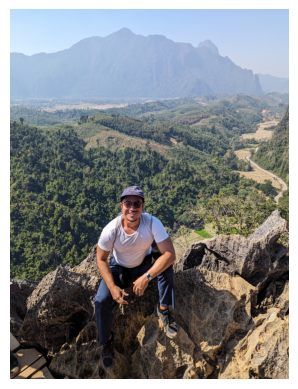

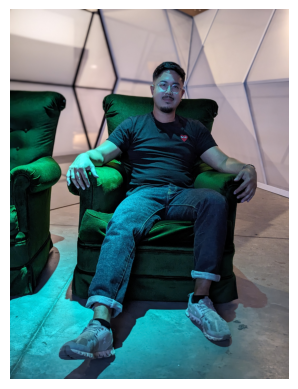

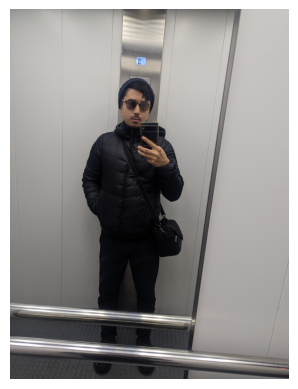

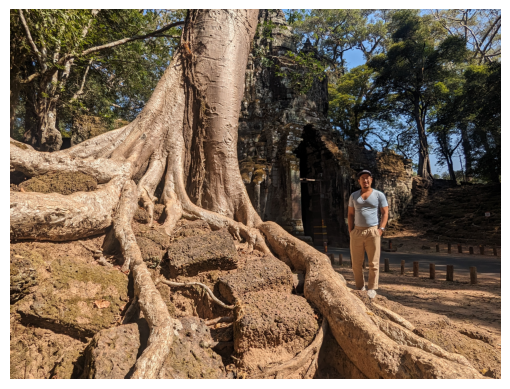

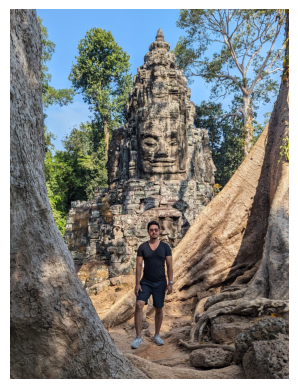

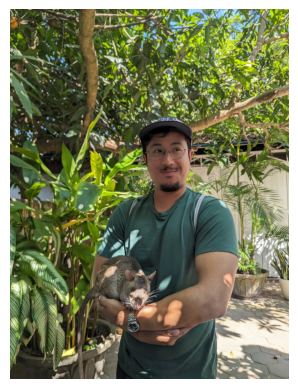

In [20]:
from PIL import Image
import matplotlib.pyplot as plt

subset = [x[0] for x in misses][0:10]

for item in subset:
    path = item   # first element of the tuple is the filepath
    img = Image.open(path)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

OK, on second thought I'm going to go the OpenAI CLIP preprocessing route first. It just feels like I'll introduce too many false positives by adjusting the threshold.

In [17]:
misses[0]

('C:\\Users\\Nick\\Documents\\who-am-i\\test_corpus\\has_faces\\PXL_20250113_053104437.jpg',
 0.680064)

In [23]:
# test block of CLIP model on one photo

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# large list of possible class prompts outlining descriptive ways to capture a text label or an artwork

primary_text_labels =   [  "a graffiti",  # classes artwork
    "a painting",
    "a statue",
    "an artwork in a museum",
    "a mural",
    "a sculpture",
    

    "a person",  # classes depicting human
    "a living human being",
    "a picture of humans at a tourist attraction",
    "a person with sunglasses on"
    ]
text_tokens = clip.tokenize(primary_text_labels).to(device)

# Encode text prompts once (saves time in loop)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# New list of misses with predictions
updated_misses = []

for img_path, *rest in tqdm(misses, desc="Classifying images"):
    try:
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            similarity = (image_features @ text_features.T).squeeze(0)

        predicted = primary_text_labels[similarity.argmax().item()]

        # Append original tuple + prediction
        updated_misses.append((img_path, *rest, predicted))

    except Exception as e:
        print(f"Error with {img_path}: {e}")
        updated_misses.append((img_path, *rest, None))

Classifying images: 100%|██████████| 465/465 [01:48<00:00,  4.29it/s]


In [42]:
# This code block makes a folder for all the photos DeepFace has verified are of me.
os.makedirs('test_corpus\\has_faces\\clip_art_indicated', exist_ok = True)

for file in [x[0] for x in updated_misses if x[2] not in ["a person","a living human being","a picture of humans at a tourist attraction","a person with sunglasses on"]]:
        name = os.path.basename(file)
    
        dest = os.path.join('test_corpus\\has_faces\\clip_art_indicated', name)
    
        try:
            shutil.move(file, dest)
        except:
            continue




In [88]:
from PIL import Image
import matplotlib.pyplot as plt

subset = [(x,y) for (x,y) in misses if os.path.basename(x) in os.listdir(os.getcwd()+'\\test_corpus\\has_faces')][140:150]

# for item in subset:
#     path = item[0]   # first element of the tuple is the filepath
#     img = Image.open(path)
#     plt.figure()
#     plt.imshow(img)
#     plt.axis("off")
#     plt.show()



In [84]:
# This code block makes a folder for all the photos DeepFace has verified are of me.
os.makedirs('test_corpus\\has_faces\\dfv_indicated_increased_thresh', exist_ok = True)

for file in [x for x, y in misses if y < np.mean([y for x, y in subset])]:
        name = os.path.basename(file)
    
        dest = os.path.join('test_corpus\\has_faces\\dfv_indicated_increased_thresh', name)
    
        try:
            shutil.move(file, dest)
        except:
            continue





I think I've reached the end of the lengths I'm willing to go to improve this pipeline any further. It's quite accurate as far as separating out the caliber of photos that I do in fact want to separate, and the rest left over I can manually drag and drop or disregard.

To summarize:

1. The first step in the pipeline relied on DeepFace.verify - which compares and determines if the two most similar faces in two separate photos are a likely match. It does this by calculating cosine distance, and then comparing if the lowest generated cosine distance from the two most similar faces across two photos are below a threshold value (determined from the model that is being used). I let this process run with one image that I chose as the general representation of my face, and then compared to all other faces in all other images. For any photos that were deemed a match, I separated them into a folder called `dfv_indicated` In this subfolder, there was only 1 false positive (of 655). Conversely, there were ~150 false negatives of 578, but I'll take that number with a grain of salt as some are really poor photos of me (face obscured, blurry, dark, etc) that I think anyone that hasn't studied my face well would slip on even.
2. As a preprocessing step (or post) I incorporated OpenAI's CLIP model to assign class labels to the balance of negatively identified images. For any picture that CLIP identified as being artwork ( "a graffiti", "a painting","a statue","an artwork in a museum","a mural","a sculpture"), I separated these into another folder `clip_art_indicated` In this folder, of 210 pictures deemed artwork, there are 43 false positives. But similar to before, these false positives really blur the categorization. They are pictures of people around artworks or artistic settings. I'll say there's only 15 I really wish it had not falsely identified as positive.
3. For my final step, from the balance images that were not allocated to either prior photo, I picked a new threshold value of cosine distance and moved any new photos below the new threshold into a new folder `dfv_indicated_increased_thresh` Of the 91 photos here, only 12 are false positives. And of the 164 remaining negatives, 51 are false negatives.
I haven't really mentioned until now, but this was a project to separate photos of myself into an album from which I could pick flattering social media / dating app photos of myself. It's why I've been so nonchalant about false negatives as these have typically been lesser quality images I wouldn't want to use. Nonetheless, it was an interesting use case around facial recognition and gave me some thoughts around it. 